## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import codecs


from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from process_email import *
from get_vocab_dict import *


## Cargar datos

In [51]:
data = loadmat('ex6data1.mat')
X1 = data['X']
Y1 = data['y'].ravel()

data = loadmat('ex6data2.mat')
X2 = data['X']
Y2 = data['y'].ravel()

data = loadmat('ex6data3.mat')
X3 = data['X']
Y3 = data['y'].ravel()
X3_val = data['Xval']
Y3_val = data['yval'].ravel()


## Función de visualizar

In [41]:
def visualize_boundary(X, y, svm, title): 
    x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100) 
    x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100) 
    x1, x2 = np.meshgrid(x1, x2) 
    yp = svm.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape) 
    pos = (y == 1).ravel() 
    neg = (y == 0).ravel() 
    plt.figure() 
    plt.scatter(X[pos, 0], X[pos, 1], color='black', marker='+') 
    plt.scatter( 
    X[neg, 0], X[neg, 1], color='yellow', edgecolors='black', marker='o') 
    plt.contour(x1, x2, yp) 
    plt.title(title)
    # plt.savefig(file_name) 
    plt.show()
    plt.close()



## Comparación de C lineal

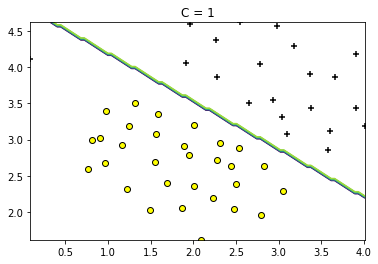

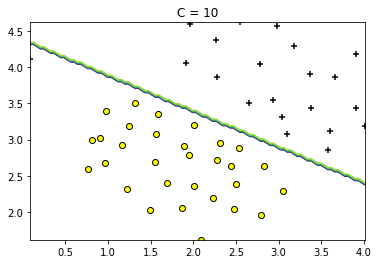

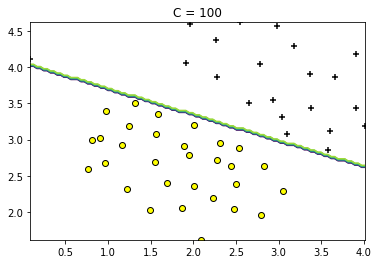

In [42]:
svmLin1 = SVC(kernel = 'linear', C = 1)
svmLin1.fit(X1, Y1)
svmLin10 = SVC(kernel = 'linear', C = 10)
svmLin10.fit(X1, Y1)
svmLin100 = SVC(kernel = 'linear', C = 100)
svmLin100.fit(X1, Y1)

visualize_boundary(X1, Y1, svmLin1, 'C = 1')
visualize_boundary(X1, Y1, svmLin10, 'C = 10')
visualize_boundary(X1, Y1, svmLin100, 'C = 100')

## Gaussian Kernel

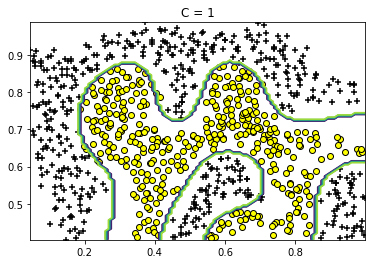

In [45]:
C = 1
sigma = .1
gamma = 1 / (2 * sigma**2)

svmGauss = SVC(kernel = 'rbf', C = C, gamma=gamma)
svmGauss.fit(X2, Y2)

visualize_boundary(X2, Y2, svmGauss, 'C = 1')

## Elección de parámetros

In [253]:
def parameter_election(X, Y, X_val, Y_val, kernel):
    values = [ .01, .03, .1, .3, 1, 3, 10, 30 ]

    cOpt = None
    sOpt = None
    accOpt = 0
    
    for C in values:
        for S in values:
            gamma = 1 / (2 * S**2) 
            
            svm = SVC(kernel=kernel, C=C, gamma=gamma)
            svm.fit(X, Y)
            acc = accuracy_score(Y_val, svm.predict(X_val))

            if(acc > accOpt):
                accOpt = acc
                cOpt = C
                sOpt = S
    
    return accOpt, cOpt, sOpt

La C óptima es: 1 y la sigma óptima es: 0.1
	con un 96.0% de precisión


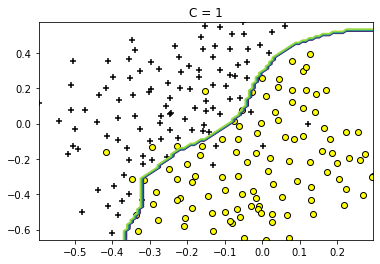

In [259]:
accOpt, cOpt, sOpt = parameter_election(X3, Y3, X3_val, Y3_val, 'rbf')

print("La C óptima es: {} y la sigma óptima es: {}\n\tcon un {}% de precisión"
      .format(cOpt, sOpt, np.round(accOpt * 100), 2))


svmOpt = SVC(kernel = 'rbf', C = cOpt, gamma=1 / (2 * sOpt**2))
svmOpt.fit(X3, Y3)
visualize_boundary(X3, Y3, svmOpt, 'C = ' + str(cOpt))

# DETECTOR DE SPAM

In [260]:
def read_dir(name='spam'):
    dic = getVocabDict()
    X = []

    for file in os.listdir(name):
        fileName = name + '/' + file
        email = email2TokenList(
                codecs.open(fileName,
                            'r',
                            encoding='utf-8',
                            errors='ignore'
                           ).read()
        )
        
        temp = np.zeros(len(dic.keys()))
        
        for v in dic.keys():
            if(v in email):
                temp[dic[v] - 1] = 1
            
                
        X.append(temp)
        
    return np.array(X)

In [239]:
XSpam = read_dir('spam')
XEasyHam = read_dir('easy_ham')
XHardHam = read_dir('hard_ham')

In [261]:
size = .8

# Join X and separate data

XSpamSize = int(XSpam.shape[0] * size)
XEasyHamSize = int(XEasyHam.shape[0] * size)
XHardHamSize = int(XHardHam.shape[0] * size)

X = np.concatenate((XSpam[:XSpamSize],
             XEasyHam[:XEasyHamSize],
             XHardHam[:XHardHamSize]))

X_val = np.concatenate((XSpam[XSpamSize:],
             XEasyHam[XEasyHamSize:],
             XHardHam[XHardHamSize:]))

In [262]:
# Create Y separated

Y = np.concatenate((
    np.ones(XSpamSize),
    np.zeros(XEasyHamSize),
    np.zeros(XHardHamSize))
)

Y_val = np.concatenate(
    (np.ones(XSpam.shape[0] - XSpamSize),
    np.zeros(XEasyHam.shape[0] - XEasyHamSize),
    np.zeros(XHardHam.shape[0] - XHardHamSize))
)

In [263]:
acc, C, sigma = parameter_election(X, Y, X_val, Y_val, 'rbf')

La mejor precisión obtenida es de 97.43
con C = 3 y sigma = 10


In [269]:
print("La mejor precisión obtenida es de un {}%\ncon C = {} y sigma = {}"
      .format(np.round(acc * 100, 2), C, sigma
))

svm = SVC(kernel = 'rbf', C = cOpt, gamma=1 / (2 * sOpt**2))
print(X.shape)

svm.fit(X, Y)
visualize_boundary(X, Y, svm, 'C = ' + str(cOpt))

La mejor precisión obtenida es de un 97.43%
con C = 3 y sigma = 10
(2640, 1899)


ValueError: X.shape[1] = 2 should be equal to 1899, the number of features at training time